# Gambling Demon

In this example, we consider a protocol where a Gambling Demon wants to put work into a system but then wants to extract work via a bit flip. The system is initialised in the ground state, and then applies a $\sigma_{x}$ rotation to the system. 

The work can easily be computed via 
\begin{equation}
\langle W_{T} \rangle = -E_{0} \Omega \int_{0}^{T} \langle \sigma_{y} \rangle dt
\end{equation}
where $\Omega$ is the frequency of the $\sigma_{y}$ is the axis of rotation. From the measured current $I(t) = \sqrt{\Gamma} \langle \sigma_{y} \rangle + \xi(t)$, we can infer the work from the raw integrated current as 
\begin{equation}
 W_{T}  = -E_{0} \Omega \int_{0}^{T} \frac{I(t)}{\sqrt{\Gamma}} dt
\end{equation}

In [71]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from _funcs import *

import seaborn as sns
plt.rc('text', usetex=True)
sns.set()

def get_first_hit(array, x):
    # create a function that returs first hitting time of array >= x
    try: 
        return np.min(np.where(array>=x))
    except ValueError:
        return None


In [85]:
# Parameters
Gamma = 1
Omega = 1
Rabi = np.sqrt((Gamma)**2 + Omega**2)
dt = 0.0012
tf = np.pi/(2*Omega)
t = np.arange(0, tf, dt)

# Define system operators
sp = sigmap()
sm = sigmam()
sx = sigmax()
sz = sigmaz()
sy = sigmay()
g = sm*sp
H = Omega*sx

# define dissipator and Hamiltonian
c_ops = [1j*np.sqrt(Gamma) * sm]    

# steadystate
rho0 = fock(2, 0)
rhoss = steadystate(H, c_ops)

unconditional_result = mesolve(H, rho0, t, c_ops=c_ops, e_ops=[sy, sz, g])
ez_un = unconditional_result.expect[1]
ey_un = unconditional_result.expect[0]
g_un = unconditional_result.expect[2]
N_cutoff = 1
# N_cu
print(tf)
print(N_cutoff)


1.5707963267948966
1


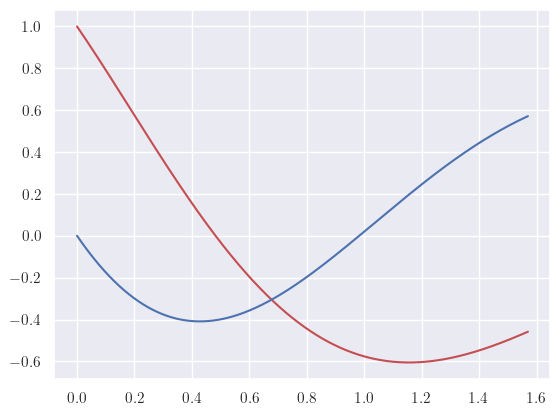

In [86]:
plt.plot(t, ez_un, label=r'$\langle \sigma_z \rangle$', color='r')
plt.plot(t, ey_un, label=r'$\langle \sigma_y \rangle$', color='b')

plt.show()

In [87]:
# number of chargers to truncate at 
Nm = 20
dN = 0.06
N = np.arange(-10, Nm, dN)

# ------ Solve n-resolved method with absorbing boundary conditions ------ #
diff = DiffusiveEvolutionPntAbsorb(H, c_ops, 1, t, N, N_cutoff, kind='single')
diff_T = DiffusiveEvolutionPnt(H, c_ops, 1, t, N)
Pn_vec = diff.solve(rho0)
Pn_vec_T = diff_T.solve(rho0)

Converting initial state to vector form


Evolution Superoperator: 100%|██████████| 1308/1308 [00:06<00:00, 205.68it/s]


Converting initial state to vector form


Evolution Superoperator: 100%|██████████| 1308/1308 [00:12<00:00, 105.39it/s]


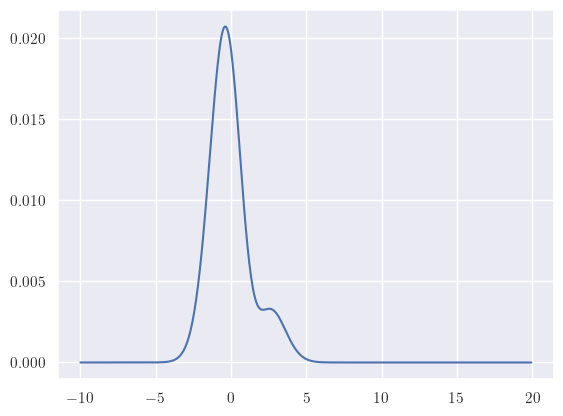

In [88]:
plt.plot(N, Pn_vec_T[:, -1], label=r'$P_n$')
plt.show()

In [89]:
# Compute survival probability from analytic solution
P0 = np.sum(Pn_vec, axis=0)
dGt = -np.gradient(P0, dt)

# Compute mean and variance of distribution
Et = np.sum(dGt * t)*dt
Var = np.sum(dGt * t**2)*dt - Et**2

np.sum(dGt)*dt

0.3230032327195539

In [90]:
ntraj = 1000
result = ssesolve(H, rho0, t, sc_ops=c_ops, e_ops=[sy, g], store_measurement=True, ntraj=ntraj)

10.0%. Run time:   1.52s. Est. time left: 00:00:00:13
20.0%. Run time:   3.07s. Est. time left: 00:00:00:12
30.0%. Run time:   4.61s. Est. time left: 00:00:00:10
40.0%. Run time:   6.14s. Est. time left: 00:00:00:09
50.0%. Run time:   7.67s. Est. time left: 00:00:00:07
60.0%. Run time:   9.22s. Est. time left: 00:00:00:06
70.0%. Run time:  10.77s. Est. time left: 00:00:00:04
80.0%. Run time:  12.32s. Est. time left: 00:00:00:03
90.0%. Run time:  13.85s. Est. time left: 00:00:00:01
Total run time:  15.36s


In [111]:
# get measurement results

Iy = np.real(np.array(result.measurement).reshape(1000, len(t)))

meas = np.real(result.measurement[0].T)[0]
meas_average = np.mean(result.measurement, axis=0).T[0]
ey = np.real(result.expect[0])
ez = np.real(result.expect[1])

int_meas = dt*np.cumsum(meas)
W = -Omega*dt*np.cumsum(Iy, axis=1)/np.sqrt(Gamma)
int_ey = dt*np.cumsum(ey)

# get first hitting time of measurement
indx = get_first_hit(int_meas, N_cutoff)
if indx is None:
    first_hit = tf
else:
    first_hit = t[indx]

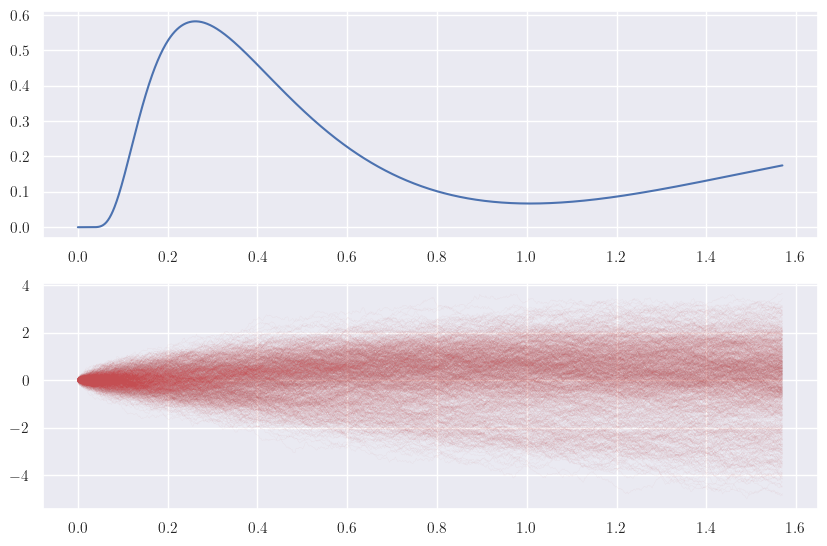

In [126]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(, 3)


ax1 = fig.add_subplot(gs[0, :])
ax1.plot(t, dGt)

ax2 = fig.add_subplot(gs[1:2, :])
ax2.plot(t, W.T, color='r', linewidth=0.2, alpha=0.1)

plt.show()


In [102]:
np.real(np.array(result.measurement).reshape(1000, len(t)))

array([[-21.72182054,  -1.37390592,  -1.37146258, ...,  25.15402981,
         31.88286584, -40.20151339],
       [ 17.15589055,  -4.58325409, -38.20169308, ..., -13.70473087,
         35.40119881, -35.10120842],
       [  8.88650724,  32.20856579,  62.22663687, ..., -30.65597147,
         -2.27774836,  17.58691755],
       ...,
       [ 40.64709884, -31.24161361,  42.07808564, ...,  22.2248886 ,
         30.74334511,  -1.85101077],
       [  1.7910964 ,  18.469001  ,  14.70756625, ...,  41.34487747,
         58.126514  ,  -1.23267103],
       [-11.83923712,  -4.27194714,  45.6917397 , ...,  -1.40229562,
        -26.57758818, -62.90898319]])